In [1]:
import numpy as np
import pandas as pd
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

# Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2
print("Keras version: ", keras.__version__)

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2
Keras version:  2.9.0


# EDA Functions

In [4]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [5]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

# Research Assignment Reporting Functions

In [6]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [7]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [8]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# Loading cifar10 Dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 15s 0us/step


# EDA Training and Test Datasets

In [10]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


# Review Labels

In [11]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10])) 
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


# Plot Subset of Examples

In [12]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [13]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

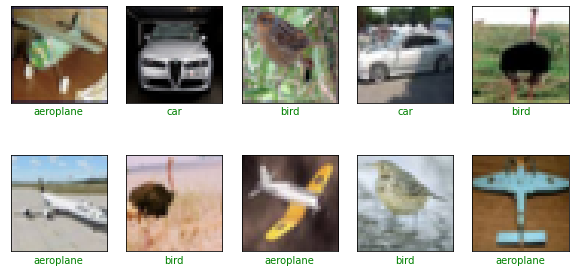

In [14]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

# Preprocessing Data for Model Development

In [15]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

# Create Validation Data Set

In [16]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

# Confirm Datasets {Train, Validation, Test}

In [17]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


# Rescale Examples {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255

1) Each element in each example is a pixel value <BR>
2) Pixel values range from 0 to 255 <BR>
3) 0 = black <BR>
4) 255 = white <BR>

In [18]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# Experiment 3 CNN

2 convolution/max pooling layers (no regularization)

In [19]:
k.clear_session()
CNN_model_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),

  Flatten(),
  Dense(units=384,activation=tf.nn.softmax),
  BatchNormalization(),
 
  Dense(units=10, activation=tf.nn.softmax)       
])

In [20]:
CNN_model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 384)               3

# Compiling the model- experiment 3 CNN

In [21]:
CNN_model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Training the model

In [22]:
history = CNN_model_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/50
704/704 [==============================] - 16s 11ms/step - loss: 1.3630 - accuracy: 0.5161 - val_loss: 1.1536 - val_accuracy: 0.5936
Epoch 2/50
704/704 [==============================] - 8s 12ms/step - loss: 0.9458 - accuracy: 0.6715 - val_loss: 1.0800 - val_accuracy: 0.6362
Epoch 3/50
704/704 [==============================] - 7s 10ms/step - loss: 0.7357 - accuracy: 0.7451 - val_loss: 0.8865 - val_accuracy: 0.7054
Epoch 4/50
704/704 [==============================] - 8s 11ms/step - loss: 0.5595 - accuracy: 0.8086 - val_loss: 0.8838 - val_accuracy: 0.7216
Epoch 5/50
704/704 [==============================] - 7s 10ms/step - loss: 0.4083 - accuracy: 0.8618 - val_loss: 0.9801 - val_accuracy: 0.7050
Epoch 6/50
704/704 [==============================] - 7s 10ms/step - loss: 0.2912 - accuracy: 0.9021 - val_loss: 0.9731 - val_accuracy: 0.7362
Epoch 7/50
704/704 [==============================] - 7s 10ms/step - loss: 0.2037 - accuracy: 0.9337 - val_loss: 1.1171 - val_accuracy: 0.718

# Evaluate the model experiment 3

In [24]:
print(f"Train acc: {CNN_model_3.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 6s 4ms/step - loss: 0.1779 - accuracy: 0.9464
Train acc: 0.946


In [25]:
print(f"Train acc: {CNN_model_3.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 4ms/step - loss: 1.5378 - accuracy: 0.6950
Train acc: 0.695


In [67]:
print(f"Test acc: {CNN_model_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 5ms/step - loss: 1.6222 - accuracy: 0.6815
Test acc: 0.682


# Predictions

In [26]:
preds = CNN_model_3.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
4,0.408,0.862,0.980,0.705
5,0.291,0.902,0.973,0.736
6,0.204,0.934,1.117,0.718
7,0.162,0.948,1.275,0.717
8,0.120,0.961,1.538,0.695


# Plot Training Metrics (Loss and Accuracy)

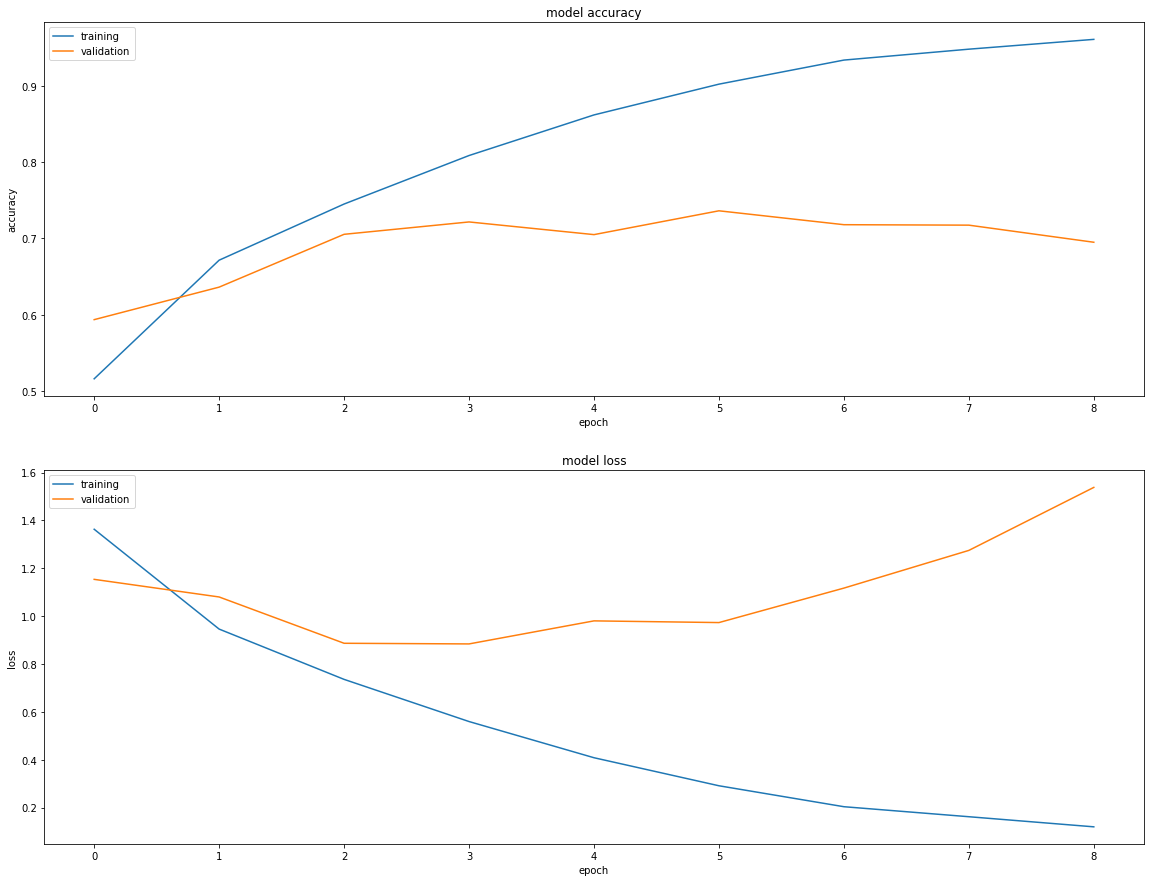

In [29]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [30]:
pred1= CNN_model_3.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [31]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1000
           1       0.83      0.78      0.81      1000
           2       0.54      0.68      0.60      1000
           3       0.41      0.59      0.48      1000
           4       0.65      0.60      0.63      1000
           5       0.61      0.57      0.59      1000
           6       0.78      0.69      0.73      1000
           7       0.75      0.73      0.74      1000
           8       0.83      0.80      0.82      1000
           9       0.89      0.62      0.73      1000

    accuracy                           0.68     10000
   macro avg       0.71      0.68      0.69     10000
weighted avg       0.71      0.68      0.69     10000

Accuracy Score: 0.6815
Root Mean Square Error: 2.2487329765892614


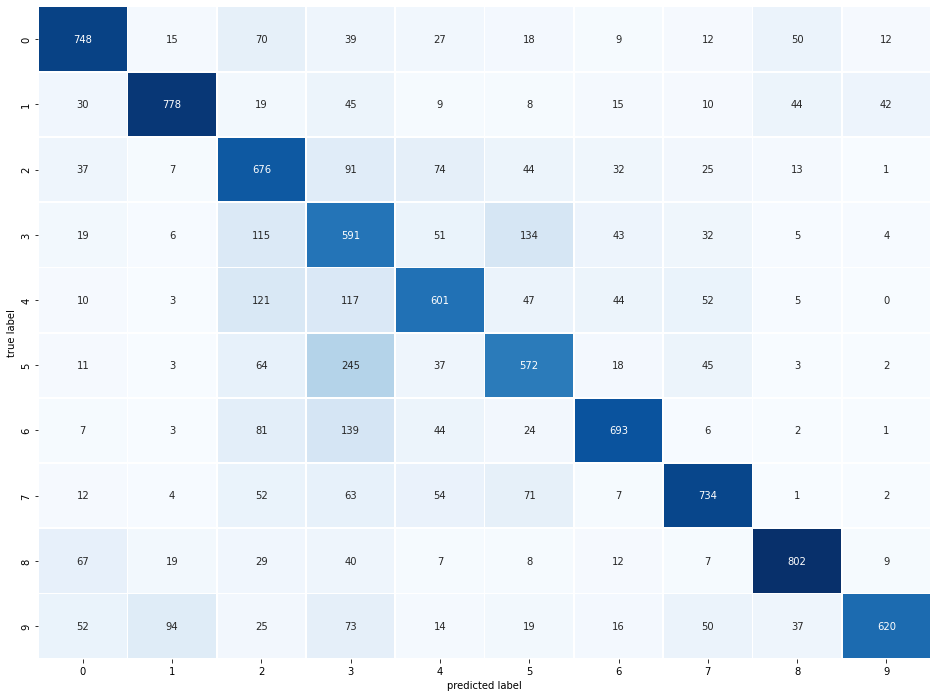

In [32]:
plot_confusion_matrix(y_test,pred1)

# Result 2 

 Extract the outputs from 2 filters from the 2 max pooling layers and visualize them in a grid as images. See whether the ‘lighted’ up regions correspond to some features in the original images.

# Load HDF5 Model Format

In [33]:
model = tf.keras.models.load_model('CNN_model.h5')

In [34]:
preds = model.predict(x_test_norm)

313/313 [==============================] - 1s 3ms/step


In [35]:
preds.shape

(10000, 10)

In [36]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [37]:
df = pd.DataFrame(preds[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.45%,0.70%,0.56%,64.55%,0.30%,17.03%,5.71%,0.24%,10.02%,0.44%
1,1.31%,9.03%,0.00%,0.01%,0.00%,0.00%,0.01%,0.00%,89.62%,0.02%
2,8.10%,14.91%,0.43%,0.24%,0.40%,0.19%,0.12%,0.24%,70.37%,5.00%
3,95.96%,1.28%,0.03%,0.05%,0.34%,0.03%,0.01%,0.41%,1.69%,0.20%
4,0.00%,0.01%,0.75%,0.51%,98.07%,0.02%,0.62%,0.01%,0.00%,0.00%
5,0.27%,0.25%,2.09%,8.52%,1.97%,11.18%,74.49%,1.02%,0.13%,0.09%
6,21.04%,41.19%,1.02%,14.15%,0.21%,1.80%,0.39%,0.73%,1.47%,18.00%
7,2.92%,0.20%,19.75%,2.11%,35.64%,0.45%,38.05%,0.33%,0.27%,0.29%
8,0.68%,0.14%,1.29%,88.22%,2.25%,5.02%,0.86%,1.36%,0.07%,0.11%
9,0.44%,89.07%,0.02%,0.02%,0.01%,0.03%,0.01%,0.01%,0.41%,9.98%


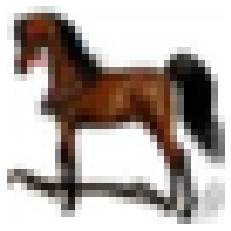

In [38]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [39]:
# Extracts the outputs of the top 4 layers:
layer_outputs = [layer.output for layer in model.layers[:4]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [40]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 94ms/step


4

In [41]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'batch_normalization',
 'dense_1']

<ipython-input-42-c015d3269387>:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


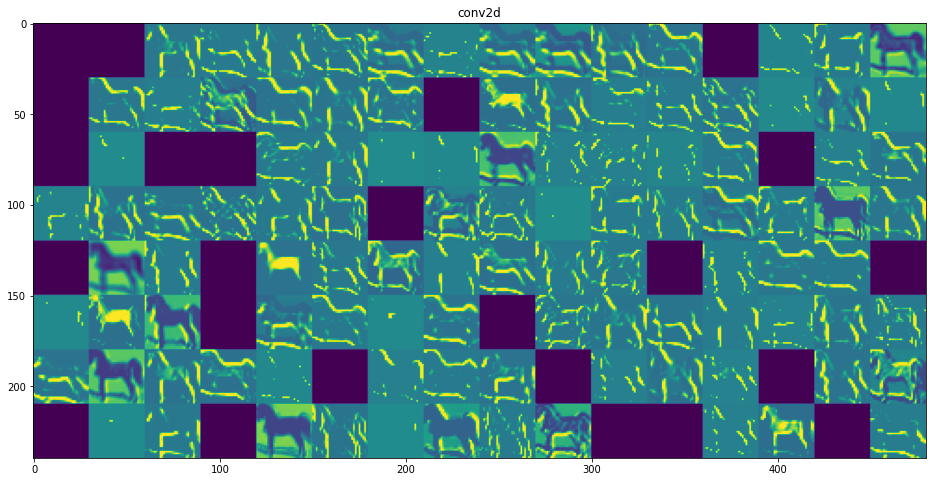

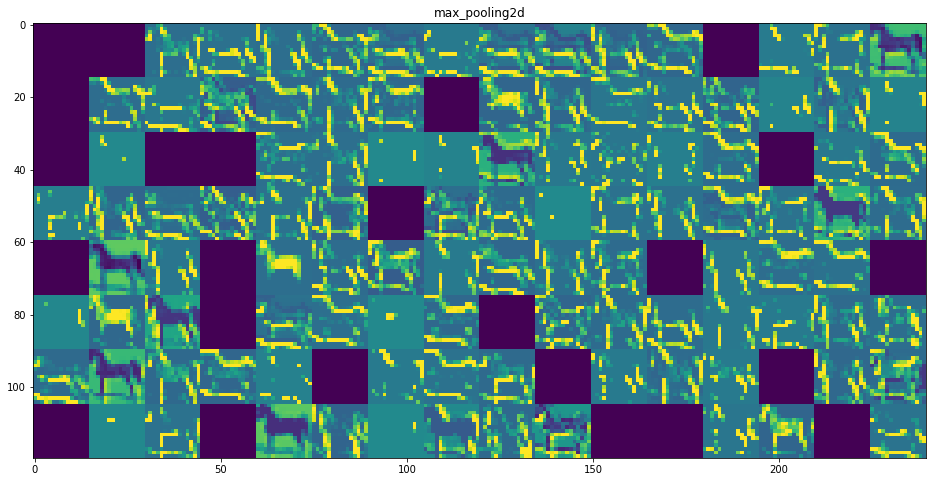

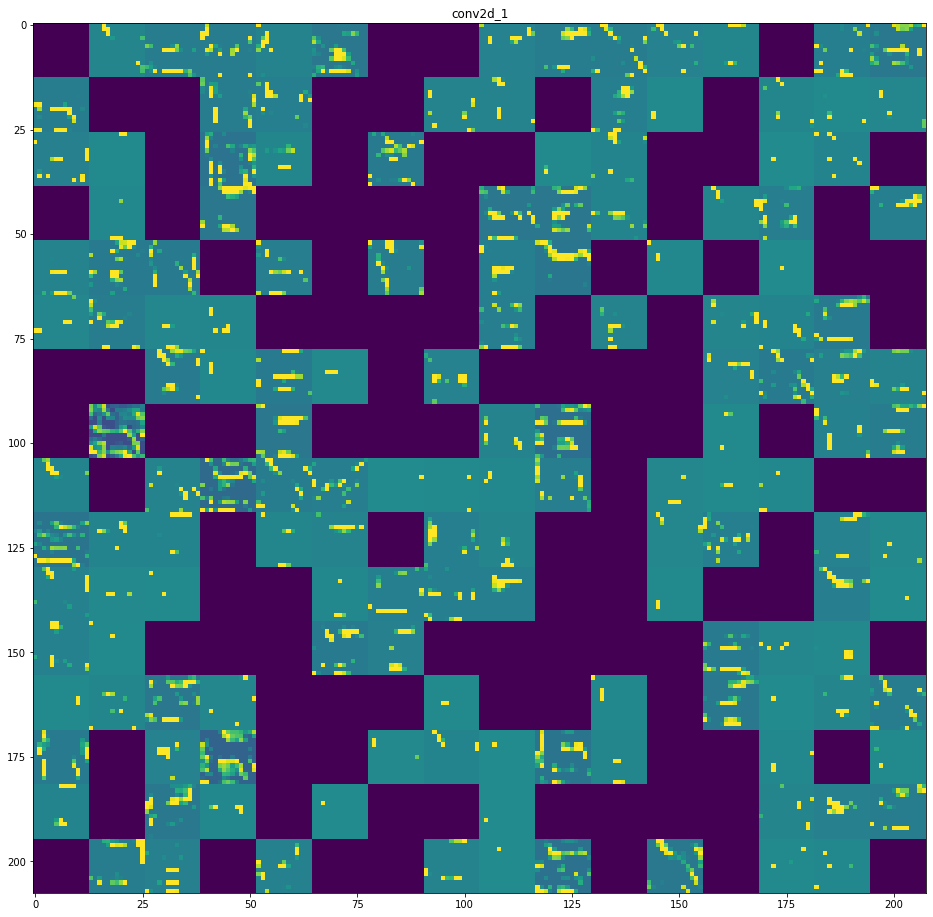

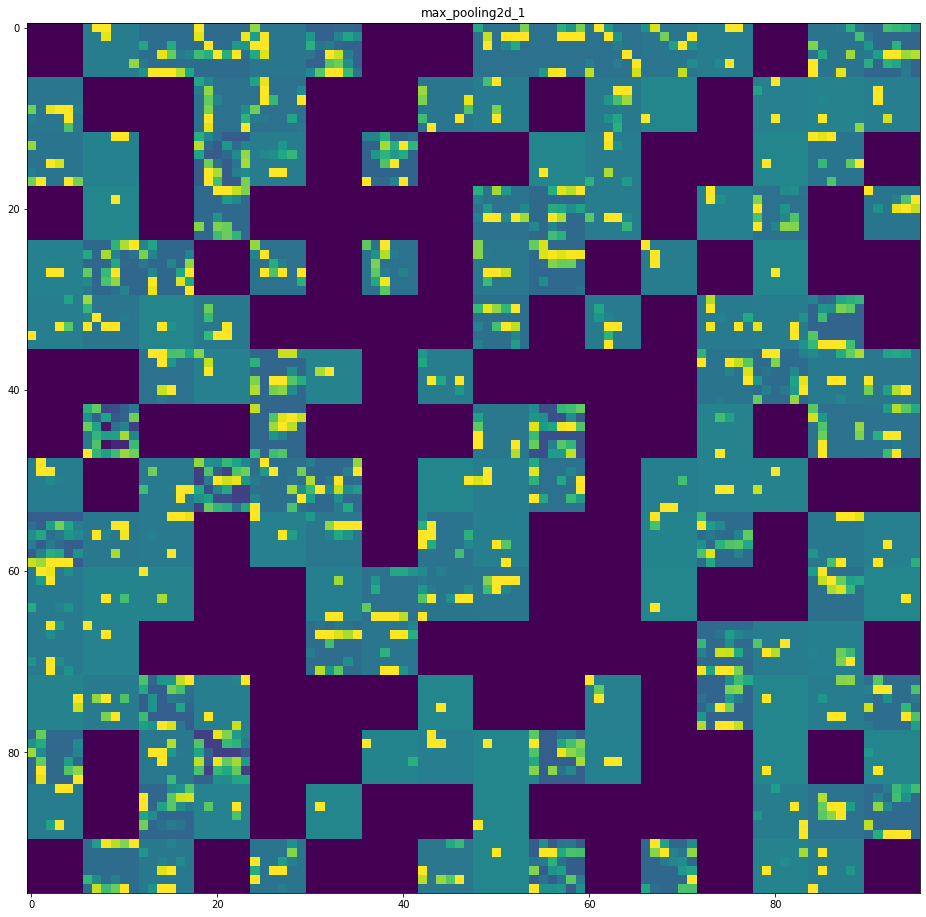

In [42]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

# Experiment 4

CNN with 3 convolution/max pooling layers (no regularization)

In [43]:
CNN_model_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
 
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax),
  BatchNormalization(),
  
  Dense(units=10, activation=tf.nn.softmax)       
])

In [44]:
CNN_model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

# Compiling the model- experiment 4

In [45]:
CNN_model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Training the model

In [46]:
history = CNN_model_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/50
704/704 [==============================] - 11s 15ms/step - loss: 1.3990 - accuracy: 0.4962 - val_loss: 1.2049 - val_accuracy: 0.5758
Epoch 2/50
704/704 [==============================] - 12s 17ms/step - loss: 0.9806 - accuracy: 0.6570 - val_loss: 1.1973 - val_accuracy: 0.5970
Epoch 3/50
704/704 [==============================] - 12s 17ms/step - loss: 0.7774 - accuracy: 0.7304 - val_loss: 0.8093 - val_accuracy: 0.7136
Epoch 4/50
704/704 [==============================] - 9s 12ms/step - loss: 0.6317 - accuracy: 0.7822 - val_loss: 0.8683 - val_accuracy: 0.7114
Epoch 5/50
704/704 [==============================] - 8s 12ms/step - loss: 0.5171 - accuracy: 0.8190 - val_loss: 0.7510 - val_accuracy: 0.7456
Epoch 6/50
704/704 [==============================] - 8s 12ms/step - loss: 0.4009 - accuracy: 0.8594 - val_loss: 0.8628 - val_accuracy: 0.7280
Epoch 7/50
704/704 [==============================] - 9s 12ms/step - loss: 0.3115 - accuracy: 0.8924 - val_loss: 0.8728 - val_accuracy: 0.7

# Evaluate the model experiment 4

In [48]:
print(f"Train acc: {CNN_model_4.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 6s 4ms/step - loss: 0.2244 - accuracy: 0.9221
Train acc: 0.922


In [49]:
print(f"Valid acc: {CNN_model_4.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 5ms/step - loss: 0.9788 - accuracy: 0.7286
Valid acc: 0.729


In [66]:
print(f"Test acc: {CNN_model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.0183 - accuracy: 0.7245
Test acc: 0.725


# Predictions

In [50]:
reds = CNN_model_4.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [51]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.632,0.782,0.868,0.711
4,0.517,0.819,0.751,0.746
5,0.401,0.859,0.863,0.728
6,0.312,0.892,0.873,0.740
7,0.242,0.918,0.979,0.729


# Plot Training Metrics (Loss and Accuracy) experiement 4


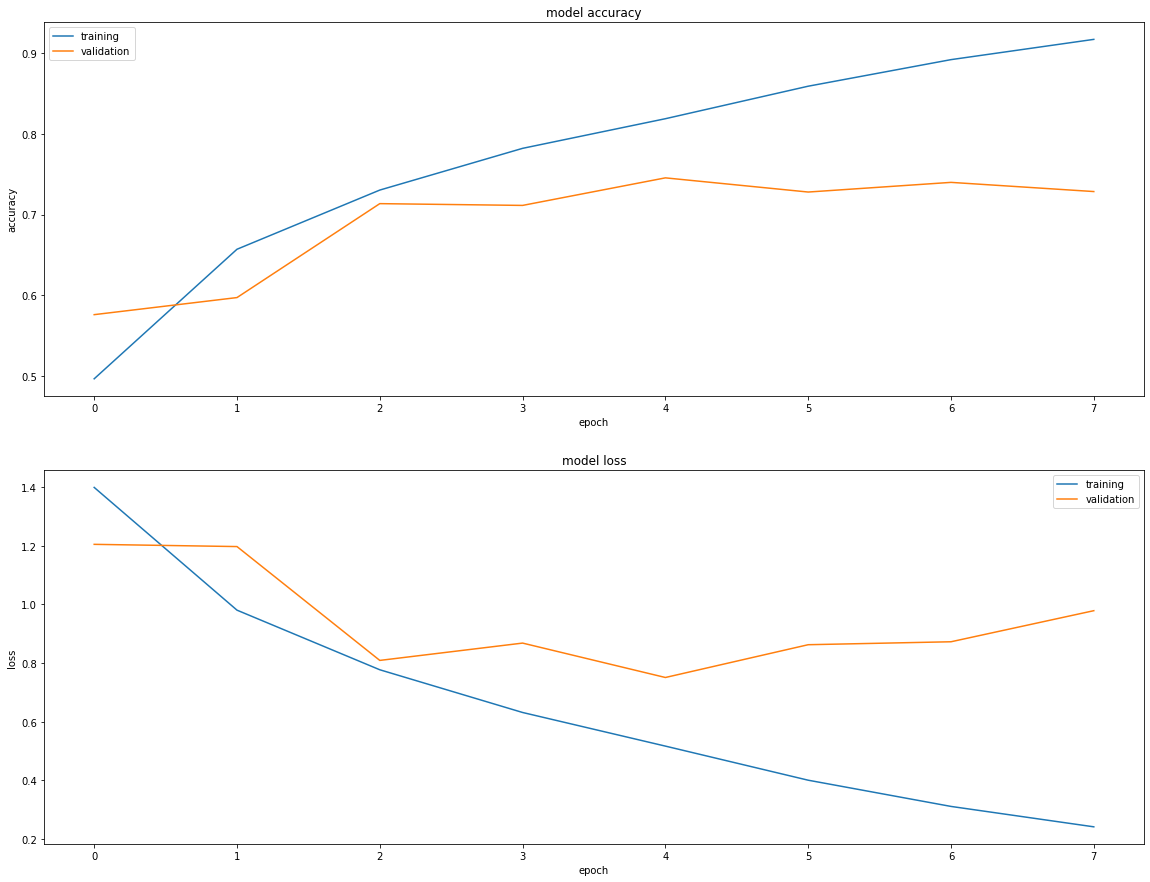

In [53]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [54]:
pred1= CNN_model_4.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [55]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      1000
           1       0.78      0.89      0.83      1000
           2       0.74      0.55      0.63      1000
           3       0.57      0.48      0.52      1000
           4       0.65      0.72      0.68      1000
           5       0.52      0.79      0.63      1000
           6       0.87      0.74      0.80      1000
           7       0.80      0.75      0.77      1000
           8       0.92      0.70      0.79      1000
           9       0.86      0.81      0.84      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.73     10000
weighted avg       0.74      0.72      0.73     10000

Accuracy Score: 0.7245
Root Mean Square Error: 2.1438749963558976


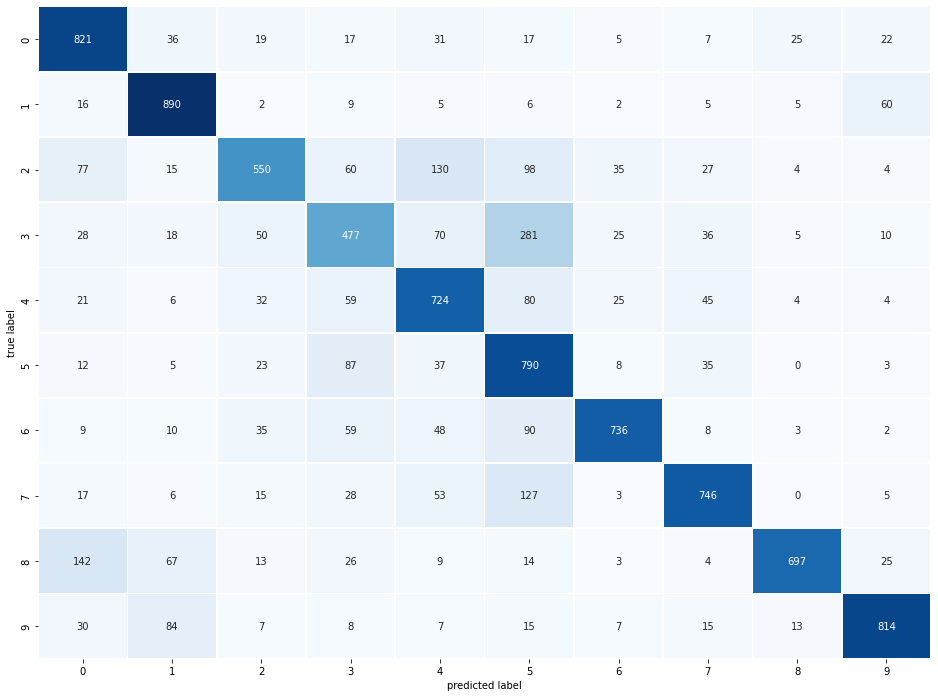

In [56]:
plot_confusion_matrix(y_test,pred1)

# Experiment 3 Reg
2 convolution/max pooling layers (with regularization)

In [57]:

CNN_model_3_reg = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.2), 
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
 
  Dense(units=10, activation=tf.nn.softmax)       
])

In [58]:
CNN_model_3_reg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)        

# Compiling the model- experiment 3 reg


In [59]:
CNN_model_3_reg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Training the model

In [60]:
history = CNN_model_3_reg.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/50
704/704 [==============================] - 10s 13ms/step - loss: 1.5515 - accuracy: 0.4905 - val_loss: 1.3577 - val_accuracy: 0.5804
Epoch 2/50
704/704 [==============================] - 11s 16ms/step - loss: 1.2489 - accuracy: 0.6223 - val_loss: 1.2738 - val_accuracy: 0.6184
Epoch 3/50
704/704 [==============================] - 8s 12ms/step - loss: 1.1388 - accuracy: 0.6692 - val_loss: 1.1976 - val_accuracy: 0.6452
Epoch 4/50
704/704 [==============================] - 8s 12ms/step - loss: 1.0763 - accuracy: 0.6959 - val_loss: 1.1143 - val_accuracy: 0.6912
Epoch 5/50
704/704 [==============================] - 8s 12ms/step - loss: 1.0249 - accuracy: 0.7170 - val_loss: 1.1248 - val_accuracy: 0.6832
Epoch 6/50
704/704 [==============================] - 8s 11ms/step - loss: 0.9796 - accuracy: 0.7389 - val_loss: 1.2512 - val_accuracy: 0.6548
Epoch 7/50
704/704 [==============================] - 8s 11ms/step - loss: 0.9508 - accuracy: 0.7511 - val_loss: 1.1018 - val_accuracy: 0.70

# Evaluate the model experiment 3 reg

In [62]:
print(f"Train acc: {CNN_model_3_reg.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 6s 4ms/step - loss: 0.6482 - accuracy: 0.8792
Train acc: 0.879


In [63]:
print(f"Valid acc: {CNN_model_3_reg.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 4ms/step - loss: 1.0943 - accuracy: 0.7366
Valid acc: 0.737


In [65]:
print(f"Test acc: {CNN_model_3_reg.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.1290 - accuracy: 0.7313
Test acc: 0.731


# Predictions

In [68]:
preds = CNN_model_3_reg.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [69]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
12,0.819,0.808,1.055,0.734
13,0.809,0.812,1.025,0.746
14,0.796,0.819,1.076,0.737
15,0.788,0.820,1.177,0.715
16,0.779,0.827,1.094,0.737


# Plot Training Metrics (Loss and Accuracy) experiement 3 reg

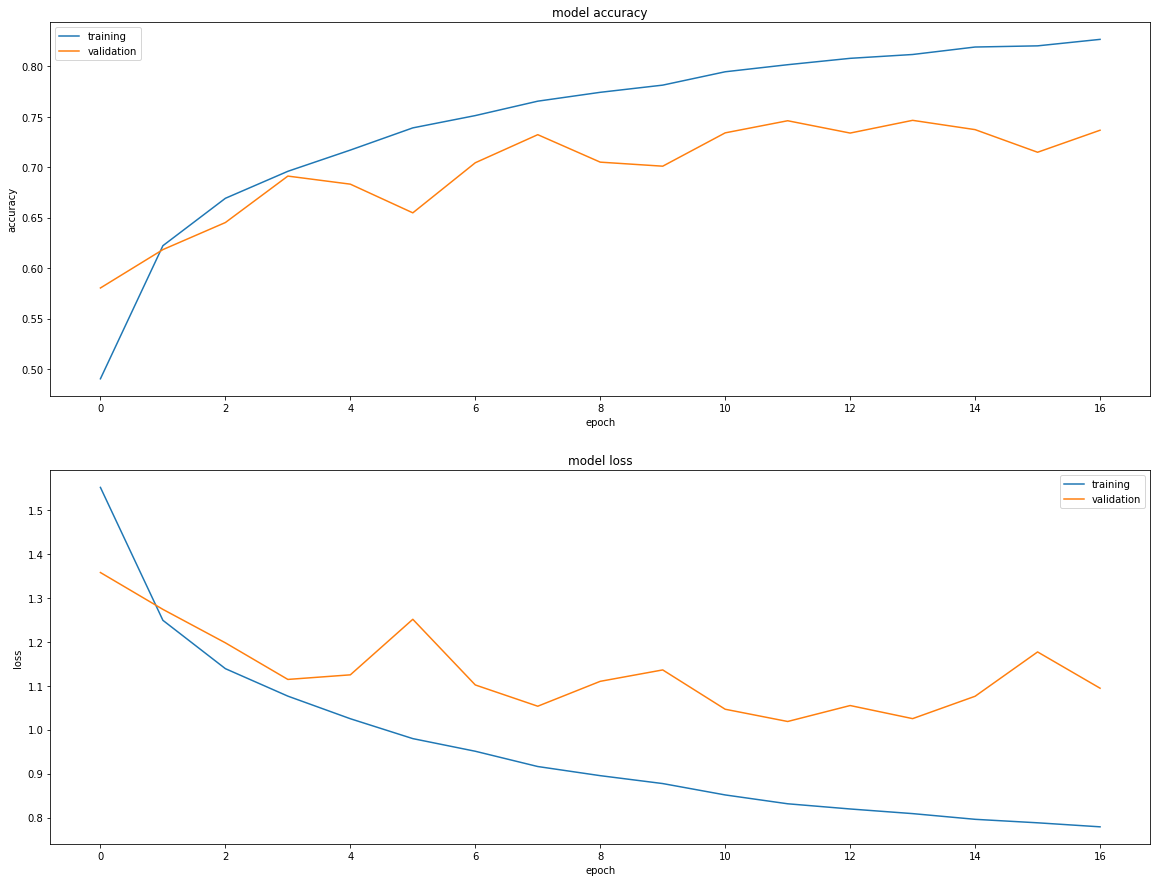

In [71]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [72]:
pred1= CNN_model_3_reg.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [73]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      1000
           1       0.91      0.83      0.87      1000
           2       0.59      0.70      0.64      1000
           3       0.54      0.59      0.57      1000
           4       0.71      0.64      0.68      1000
           5       0.79      0.51      0.62      1000
           6       0.66      0.89      0.76      1000
           7       0.72      0.84      0.77      1000
           8       0.84      0.83      0.83      1000
           9       0.84      0.80      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000

Accuracy Score: 0.7313
Root Mean Square Error: 2.0738852427268006


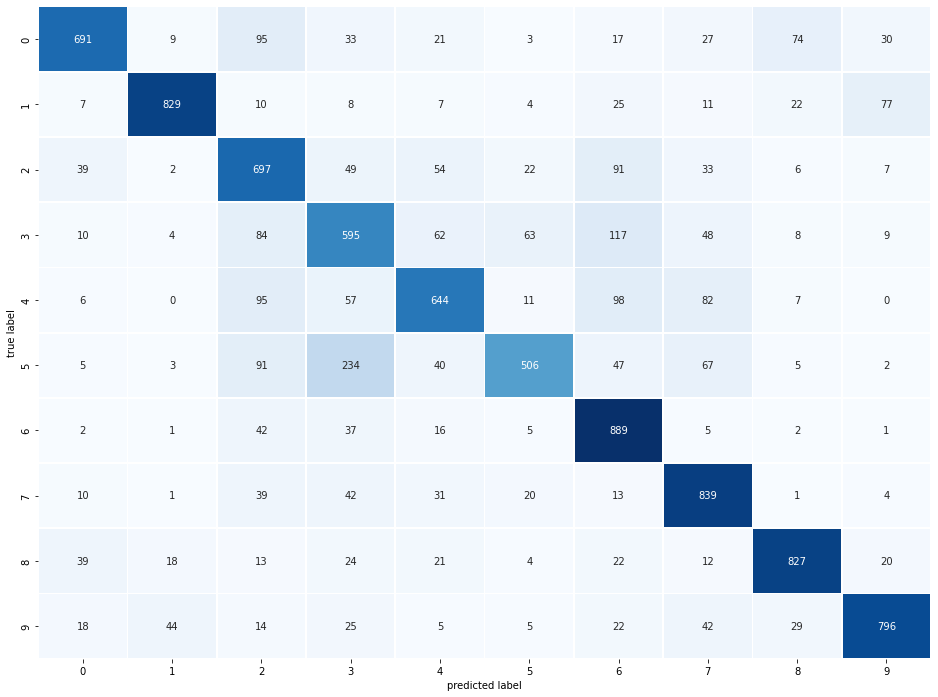

In [74]:
plot_confusion_matrix(y_test,pred1)

# Experiment 4 Regularization
CNN with 3 convolution/max pooling layers (with regularization)

In [75]:
CNN_model_4_reg = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.2),
 
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.2),
  
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.2),
  
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  
  Dense(units=10, activation=tf.nn.softmax)       
])

In [76]:
CNN_model_4_reg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 256)        

# Compiling the model- experiment 4 reg

In [77]:
CNN_model_4_reg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Training the model

In [78]:
history = CNN_model_4_reg.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/50
704/704 [==============================] - 13s 17ms/step - loss: 1.5750 - accuracy: 0.4516 - val_loss: 1.3276 - val_accuracy: 0.5416
Epoch 2/50
704/704 [==============================] - 10s 15ms/step - loss: 1.1801 - accuracy: 0.6047 - val_loss: 1.1181 - val_accuracy: 0.6144
Epoch 3/50
704/704 [==============================] - 11s 15ms/step - loss: 1.0180 - accuracy: 0.6668 - val_loss: 1.1472 - val_accuracy: 0.6284
Epoch 4/50
704/704 [==============================] - 9s 13ms/step - loss: 0.9138 - accuracy: 0.7075 - val_loss: 0.9896 - val_accuracy: 0.6842
Epoch 5/50
704/704 [==============================] - 9s 13ms/step - loss: 0.8315 - accuracy: 0.7388 - val_loss: 0.8233 - val_accuracy: 0.7398
Epoch 6/50
704/704 [==============================] - 9s 13ms/step - loss: 0.7818 - accuracy: 0.7564 - val_loss: 0.8091 - val_accuracy: 0.7506
Epoch 7/50
704/704 [==============================] - 9s 13ms/step - loss: 0.7252 - accuracy: 0.7773 - val_loss: 0.8176 - val_accuracy: 0.7

# Evaluate the model experiment 4 reg

In [ ]:
model = tf.keras.models.load_model("CNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.7832 - accuracy: 0.7661
Test acc: 0.766


In [79]:
print(f"Train acc: {CNN_model_4_reg.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 6s 4ms/step - loss: 0.4417 - accuracy: 0.8808
Train acc: 0.881


In [80]:
print(f"Valid acc: {CNN_model_4_reg.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 4ms/step - loss: 0.7844 - accuracy: 0.7632
Valid acc: 0.763


In [81]:
print(f"Test acc: {CNN_model_4_reg.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.8238 - accuracy: 0.7594
Test acc: 0.759


# Predictions

In [82]:
preds = CNN_model_4_reg.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [83]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [84]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
6,0.725,0.777,0.818,0.747
7,0.686,0.790,0.764,0.767
8,0.653,0.802,0.813,0.747
9,0.622,0.813,0.803,0.761
10,0.597,0.823,0.784,0.763


# Plot Training Metrics (Loss and Accuracy) experiement 4 reg

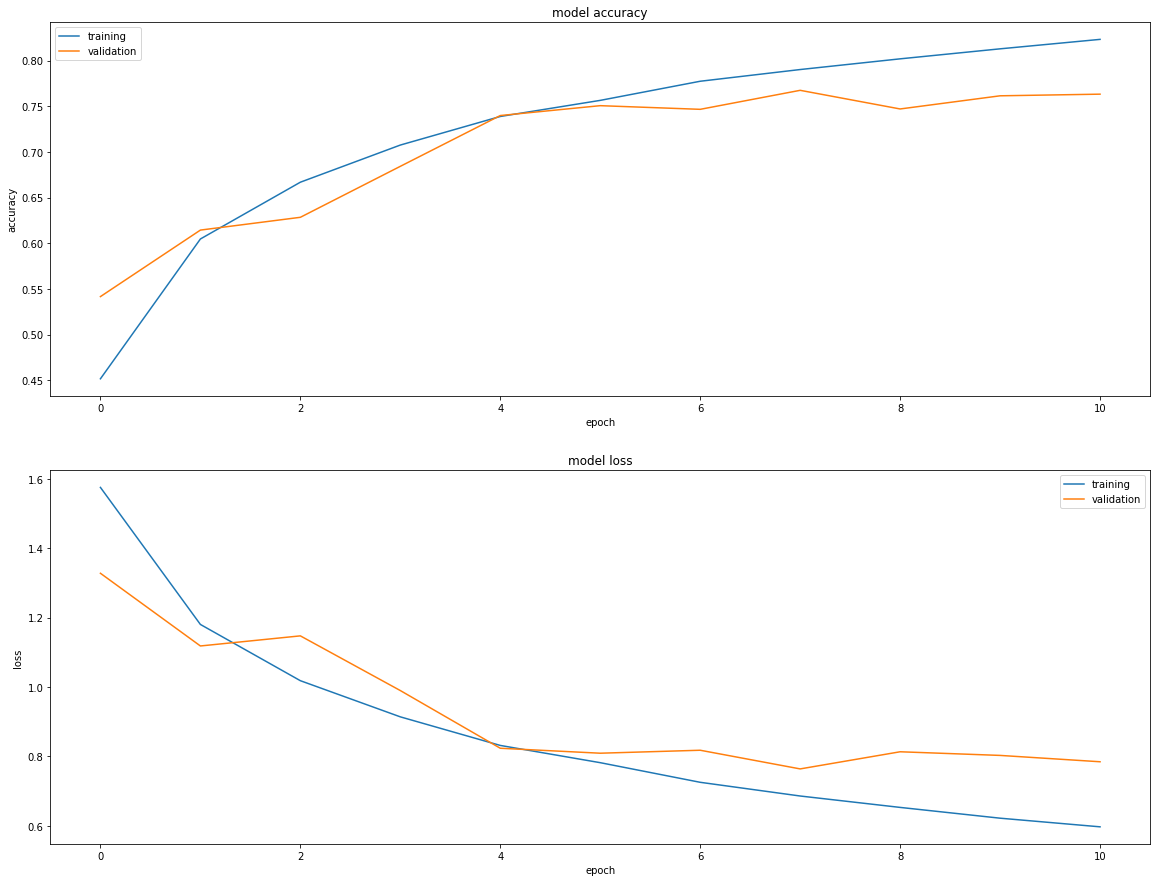

In [85]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [86]:
pred1= CNN_model_4_reg.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [87]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1000
           1       0.89      0.89      0.89      1000
           2       0.72      0.61      0.67      1000
           3       0.54      0.66      0.59      1000
           4       0.69      0.78      0.73      1000
           5       0.73      0.61      0.66      1000
           6       0.65      0.91      0.76      1000
           7       0.92      0.67      0.77      1000
           8       0.86      0.89      0.88      1000
           9       0.87      0.82      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000

Accuracy Score: 0.7594
Root Mean Square Error: 1.935045219109879


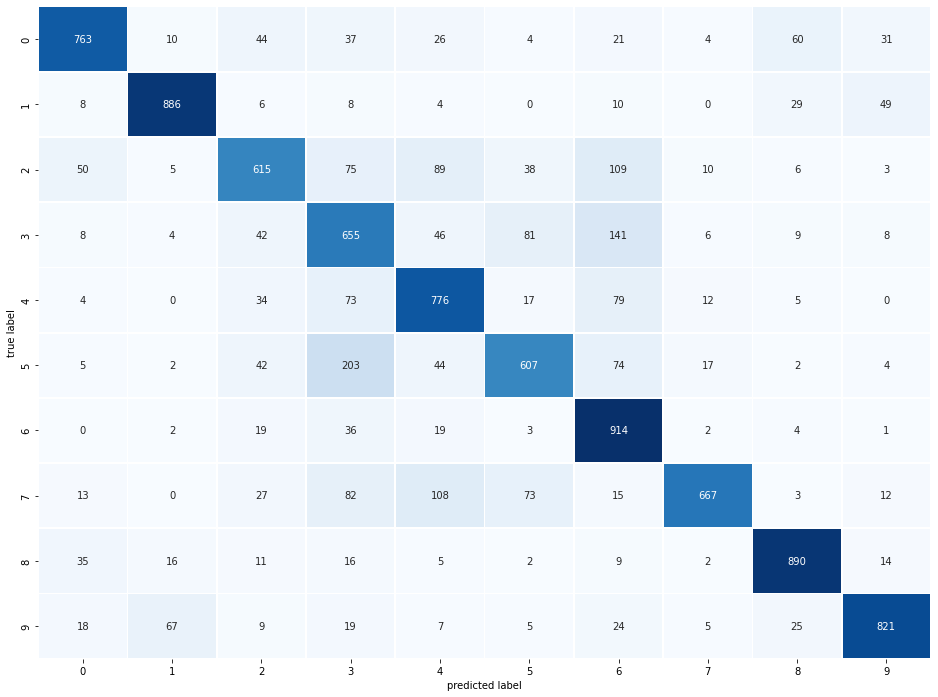

In [88]:
plot_confusion_matrix(y_test,pred1)

In [ ]:
#try next experiment with strides and paddings

# Experiment 5
change by swapping stride for padding

In [89]:
CNN_model_5_reg = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2)),
  Dropout(0.2),
 
  Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
  MaxPool2D((2, 2)),
  Dropout(0.2),
  
  Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
  MaxPool2D((2, 2)),
  Dropout(0.2),
  
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  
  Dense(units=10, activation=tf.nn.softmax)       
])

In [90]:
CNN_model_5_reg.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 256)        

# Compiling the model- experiment 5

In [91]:
CNN_model_5_reg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Training the model

In [92]:
history = CNN_model_5_reg.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/50
704/704 [==============================] - 14s 19ms/step - loss: 1.5255 - accuracy: 0.4913 - val_loss: 1.3556 - val_accuracy: 0.5430
Epoch 2/50
704/704 [==============================] - 15s 21ms/step - loss: 1.1331 - accuracy: 0.6470 - val_loss: 1.0550 - val_accuracy: 0.6782
Epoch 3/50
704/704 [==============================] - 11s 16ms/step - loss: 0.9902 - accuracy: 0.7035 - val_loss: 1.0358 - val_accuracy: 0.6880
Epoch 4/50
704/704 [==============================] - 11s 16ms/step - loss: 0.9068 - accuracy: 0.7336 - val_loss: 0.9288 - val_accuracy: 0.7336
Epoch 5/50
704/704 [==============================] - 11s 16ms/step - loss: 0.8423 - accuracy: 0.7597 - val_loss: 0.8811 - val_accuracy: 0.7592
Epoch 6/50
704/704 [==============================] - 11s 16ms/step - loss: 0.7927 - accuracy: 0.7780 - val_loss: 0.9631 - val_accuracy: 0.7378
Epoch 7/50
704/704 [==============================] - 11s 16ms/step - loss: 0.7502 - accuracy: 0.7978 - val_loss: 0.8652 - val_accuracy:

# Evaluate the model experiment 5 reg

In [93]:
print(f"Train acc: {CNN_model_5_reg.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 7s 5ms/step - loss: 0.4757 - accuracy: 0.9060
Train acc: 0.906


In [94]:
print(f"Valid acc: {CNN_model_5_reg.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 5ms/step - loss: 0.8714 - accuracy: 0.7786
Valid acc: 0.779


In [95]:
print(f"Test acc: {CNN_model_5_reg.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.9060 - accuracy: 0.7687
Test acc: 0.769


# Predictions

In [96]:
preds = CNN_model_5_reg.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics 

In [97]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [98]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
9,0.668,0.830,0.932,0.749
10,0.651,0.836,0.804,0.790
11,0.628,0.846,0.878,0.771
12,0.616,0.851,0.826,0.781
13,0.601,0.856,0.871,0.779


# Plot Training Metrics (Loss and Accuracy) experiement 5 reg

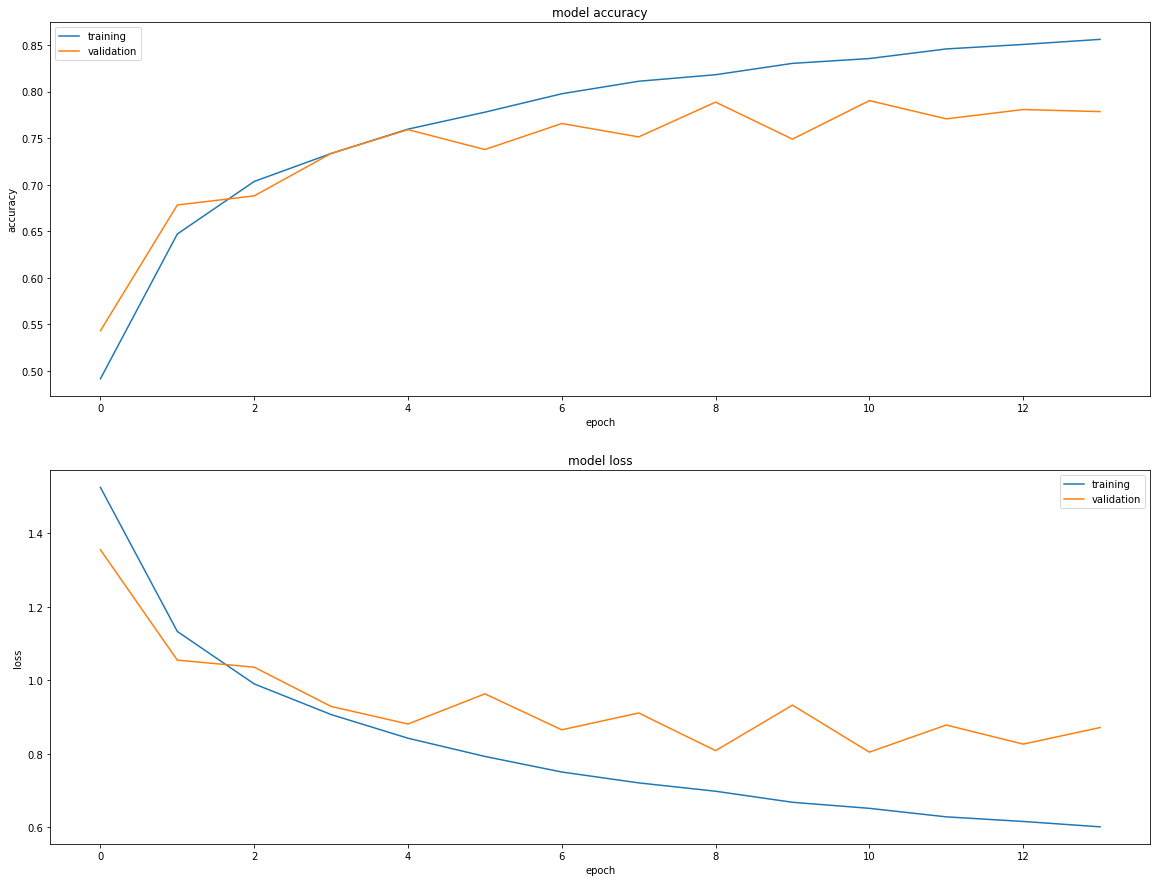

In [99]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [100]:
pred1= CNN_model_5_reg.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [101]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.93      0.75      1000
           1       0.91      0.89      0.90      1000
           2       0.72      0.62      0.67      1000
           3       0.62      0.59      0.61      1000
           4       0.73      0.77      0.75      1000
           5       0.83      0.55      0.66      1000
           6       0.72      0.92      0.80      1000
           7       0.85      0.80      0.82      1000
           8       0.89      0.82      0.85      1000
           9       0.93      0.80      0.86      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

Accuracy Score: 0.7687
Root Mean Square Error: 2.063904067538024


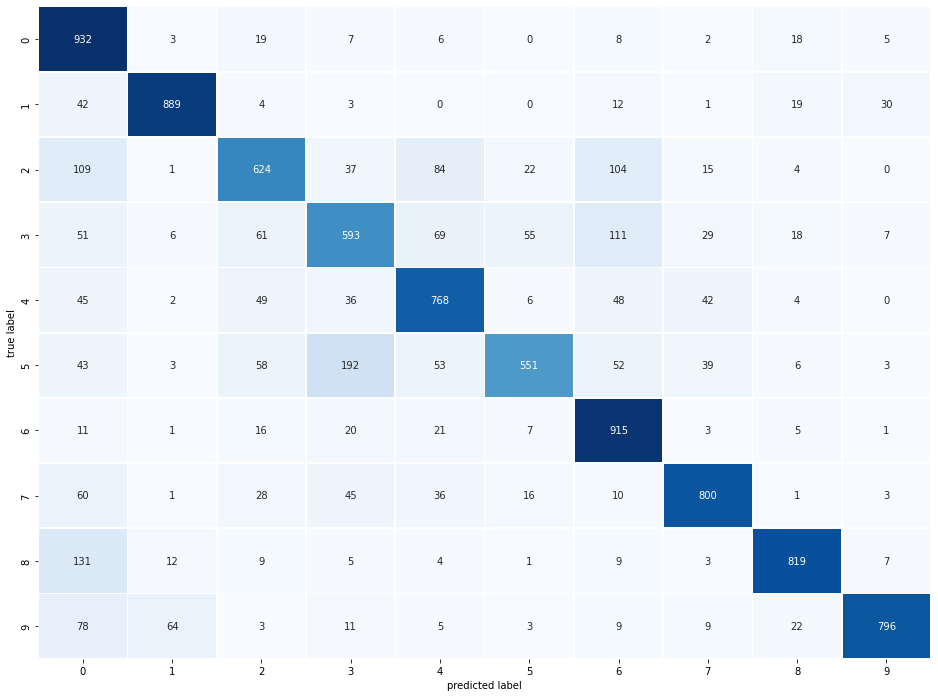

In [102]:
plot_confusion_matrix(y_test,pred1)

# Experiment 6

changes from experiment 5 <br>
lower dense units from 384 to 96 (half) but add an additional layer

In [103]:
CNN_model_6_reg = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2)),
  Dropout(0.2),
 
  Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
  MaxPool2D((2, 2)),
  Dropout(0.2),
  
  Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
  MaxPool2D((2, 2)),
  Dropout(0.2),

  Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
  MaxPool2D((2, 2)),
  Dropout(0.2),
  
  Flatten(),
  Dense(units=96,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  
  Dense(units=10, activation=tf.nn.softmax)       
])

In [104]:
CNN_model_6_reg.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 256)        

# Compiling the model- experiment 6

In [105]:
CNN_model_6_reg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Training the model

In [106]:
history = CNN_model_6_reg.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/50
704/704 [==============================] - 17s 23ms/step - loss: 1.4808 - accuracy: 0.4835 - val_loss: 1.3233 - val_accuracy: 0.5442
Epoch 2/50
704/704 [==============================] - 16s 22ms/step - loss: 1.0515 - accuracy: 0.6466 - val_loss: 0.9915 - val_accuracy: 0.6644
Epoch 3/50
704/704 [==============================] - 14s 20ms/step - loss: 0.8847 - accuracy: 0.7082 - val_loss: 0.8528 - val_accuracy: 0.7156
Epoch 4/50
704/704 [==============================] - 14s 20ms/step - loss: 0.7821 - accuracy: 0.7465 - val_loss: 0.7762 - val_accuracy: 0.7446
Epoch 5/50
704/704 [==============================] - 13s 19ms/step - loss: 0.7085 - accuracy: 0.7729 - val_loss: 0.8970 - val_accuracy: 0.7052
Epoch 6/50
704/704 [==============================] - 14s 20ms/step - loss: 0.6520 - accuracy: 0.7931 - val_loss: 0.7538 - val_accuracy: 0.7554
Epoch 7/50
704/704 [==============================] - 13s 19ms/step - loss: 0.6079 - accuracy: 0.8094 - val_loss: 0.6979 - val_accuracy:

# Evaluate the model experiment 6 reg

In [107]:
print(f"Train acc: {CNN_model_6_reg.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 7s 5ms/step - loss: 0.2653 - accuracy: 0.9387
Train acc: 0.939


In [108]:
print(f"Valid acc: {CNN_model_6_reg.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 5ms/step - loss: 0.7427 - accuracy: 0.7778
Valid acc: 0.778


In [109]:
print(f"Test acc: {CNN_model_6_reg.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 0.7645 - accuracy: 0.7775
Test acc: 0.777


# Predictions

In [110]:
preds = CNN_model_6_reg.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 2s 4ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [111]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [112]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
9,0.493,0.851,0.730,0.776
10,0.470,0.858,0.636,0.810
11,0.451,0.866,0.681,0.798
12,0.432,0.873,0.672,0.799
13,0.413,0.881,0.743,0.778


# Plot Training Metrics (Loss and Accuracy) experiement 6 reg

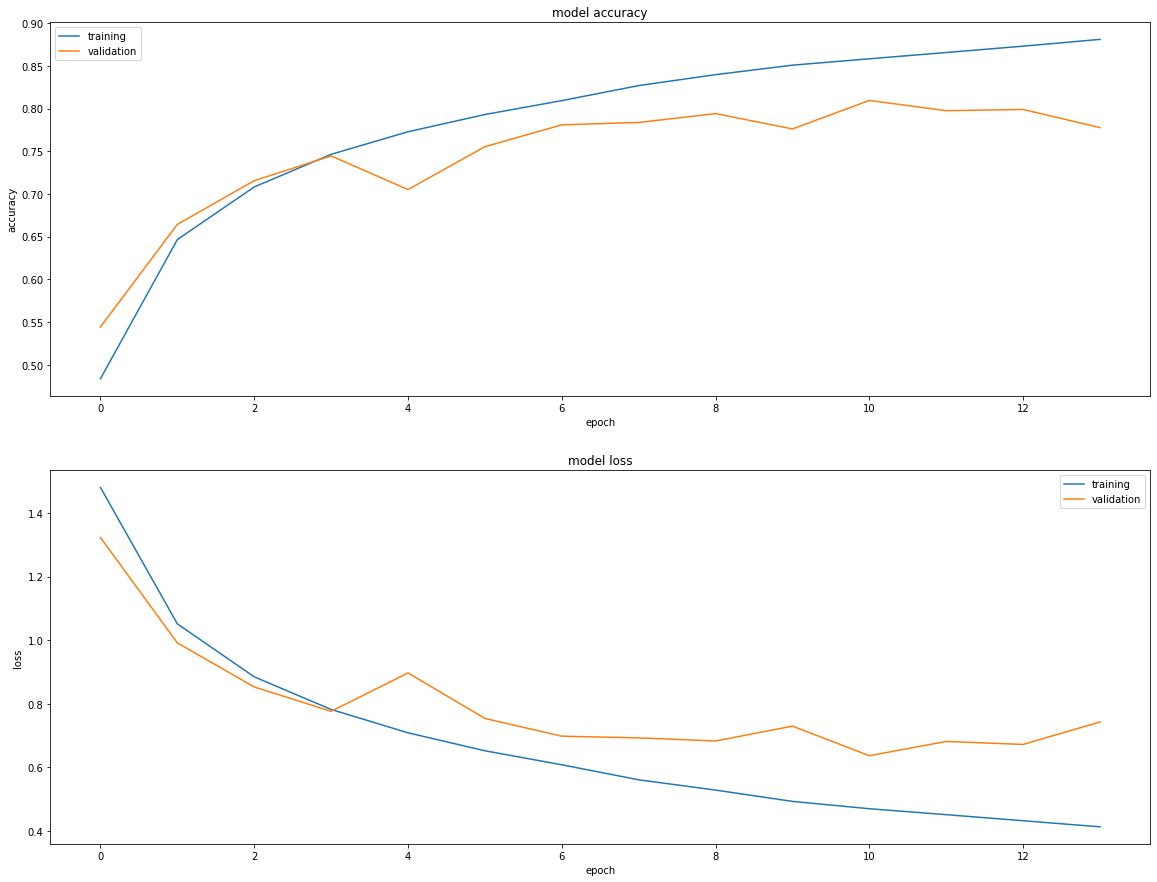

In [113]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [114]:
pred1= CNN_model_6_reg.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 4ms/step


In [115]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      1000
           1       0.94      0.88      0.91      1000
           2       0.80      0.56      0.66      1000
           3       0.57      0.60      0.59      1000
           4       0.72      0.81      0.76      1000
           5       0.62      0.79      0.69      1000
           6       0.71      0.92      0.80      1000
           7       0.90      0.74      0.81      1000
           8       0.91      0.84      0.87      1000
           9       0.86      0.89      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

Accuracy Score: 0.7775
Root Mean Square Error: 1.811629101113139


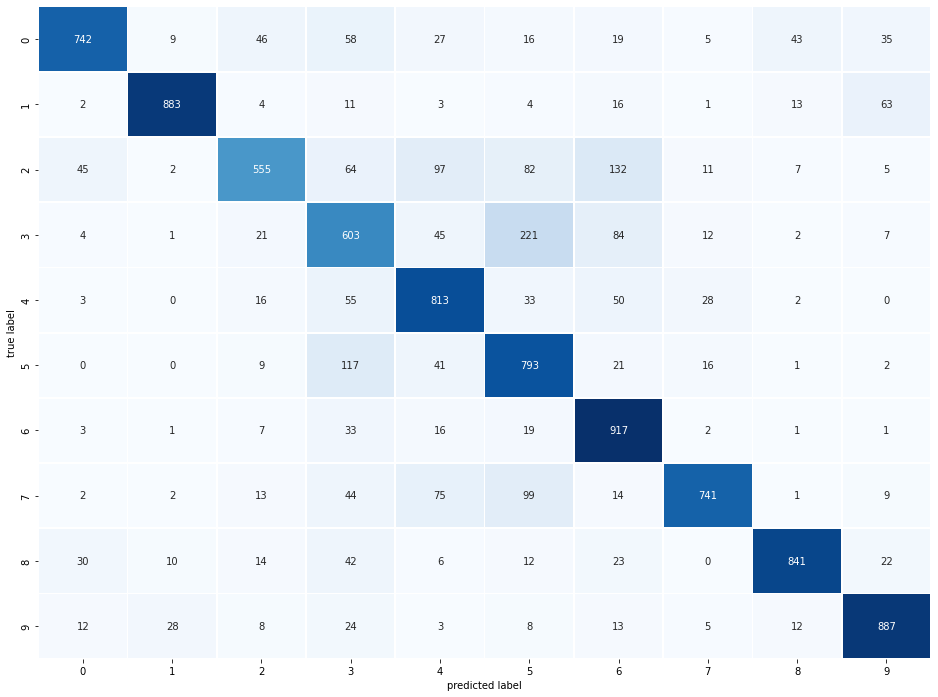

In [116]:
plot_confusion_matrix(y_test,pred1)

# Experiment 7 CNN 

changes from experiment 6 - add additional layers 1 but decrease filters on existing hidden layers

In [117]:
CNN_model_7_reg = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2)),
  Dropout(0.25),
 
  Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
  MaxPool2D((2, 2)),
  Dropout(0.25),

  Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
  MaxPool2D((2, 2)),
  Dropout(0.25),
  
  Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
  MaxPool2D((2, 2)),
  Dropout(0.25),

  Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
  MaxPool2D((2, 2)),
  Dropout(0.25),
  
  Flatten(),
  Dense(units=96,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  
  Dense(units=10, activation=tf.nn.softmax)       
])

In [118]:
CNN_model_7_reg.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 8, 8, 128)        

# Compiling the model- experiment 7

In [119]:
CNN_model_7_reg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Training the model

In [120]:
history = CNN_model_7_reg.fit(x_train_norm
                    ,y_train_split
                    ,epochs=50
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/50
704/704 [==============================] - 14s 18ms/step - loss: 1.6183 - accuracy: 0.4180 - val_loss: 1.3090 - val_accuracy: 0.5372
Epoch 2/50
704/704 [==============================] - 11s 16ms/step - loss: 1.1964 - accuracy: 0.5799 - val_loss: 1.1039 - val_accuracy: 0.6094
Epoch 3/50
704/704 [==============================] - 12s 17ms/step - loss: 1.0258 - accuracy: 0.6440 - val_loss: 0.9686 - val_accuracy: 0.6540
Epoch 4/50
704/704 [==============================] - 10s 14ms/step - loss: 0.9225 - accuracy: 0.6849 - val_loss: 0.8442 - val_accuracy: 0.7110
Epoch 5/50
704/704 [==============================] - 9s 13ms/step - loss: 0.8513 - accuracy: 0.7117 - val_loss: 0.8264 - val_accuracy: 0.7170
Epoch 6/50
704/704 [==============================] - 9s 13ms/step - loss: 0.8006 - accuracy: 0.7282 - val_loss: 0.7767 - val_accuracy: 0.7472
Epoch 7/50
704/704 [==============================] - 9s 13ms/step - loss: 0.7550 - accuracy: 0.7448 - val_loss: 0.7477 - val_accuracy: 0.

# Evaluate the model experiment 7 reg

In [121]:
print(f"Train acc: {CNN_model_7_reg.evaluate(x_train_norm, y_train_split)[1]:.3f}")

1407/1407 [==============================] - 6s 4ms/step - loss: 0.4345 - accuracy: 0.8616
Train acc: 0.862


In [122]:
print(f"Valid acc: {CNN_model_7_reg.evaluate(x_valid_norm, y_valid_split)[1]:.3f}")

157/157 [==============================] - 1s 4ms/step - loss: 0.7105 - accuracy: 0.7732
Valid acc: 0.773


In [123]:
print(f"Test acc: {CNN_model_7_reg.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.7197 - accuracy: 0.7668
Test acc: 0.767


# Predictions

In [ ]:
preds = CNN_model_7_reg.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


# Plotting Performance Metrics

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
19,0.556,0.818,0.619,0.798
20,0.545,0.821,0.602,0.808
21,0.543,0.821,0.624,0.803
22,0.534,0.825,0.625,0.799
23,0.533,0.827,0.605,0.806


# Plot Training Metrics (Loss and Accuracy) experiement 7 reg

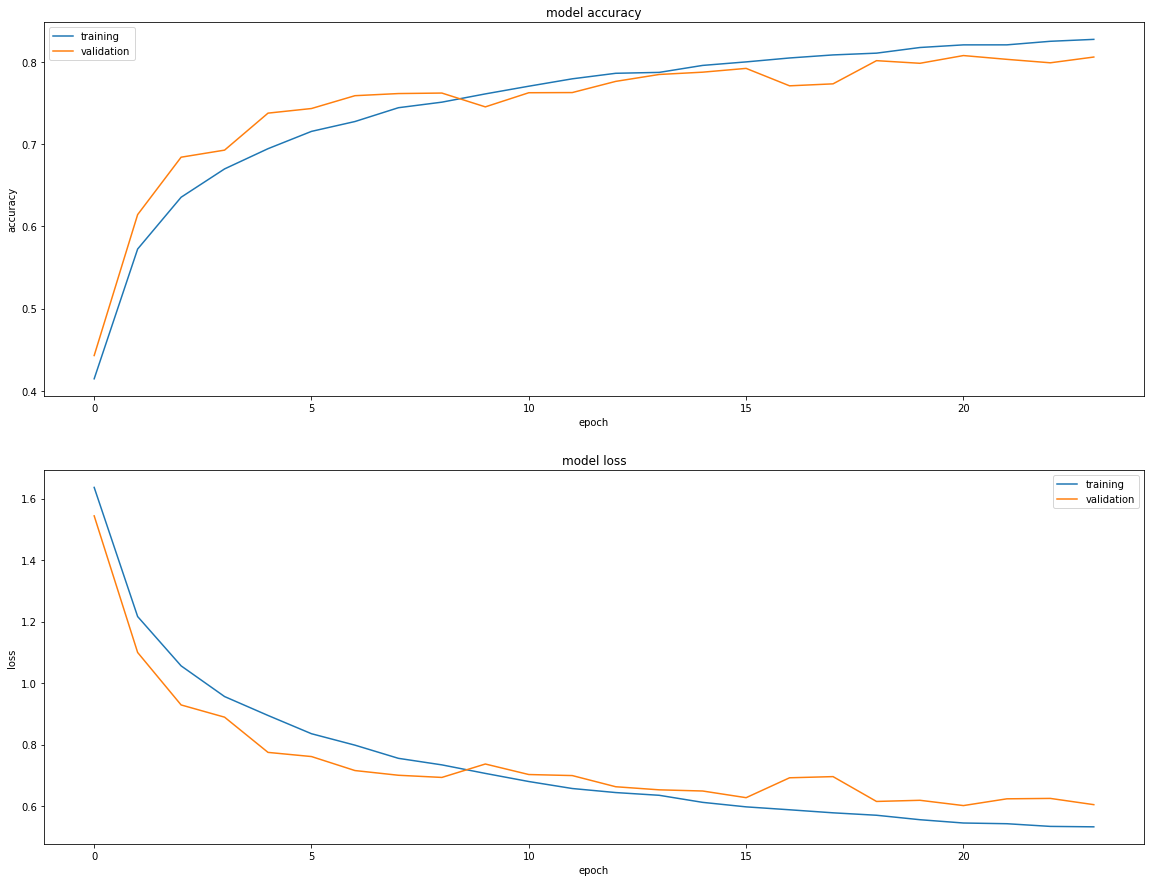

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Confusion matrices

In [ ]:
pred1= CNN_model_7_reg.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1000
           1       0.96      0.83      0.89      1000
           2       0.74      0.71      0.72      1000
           3       0.59      0.69      0.64      1000
           4       0.73      0.78      0.76      1000
           5       0.78      0.65      0.70      1000
           6       0.87      0.81      0.84      1000
           7       0.83      0.84      0.83      1000
           8       0.83      0.92      0.87      1000
           9       0.83      0.90      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

Accuracy Score: 0.7939
Root Mean Square Error: 1.8618002041035444


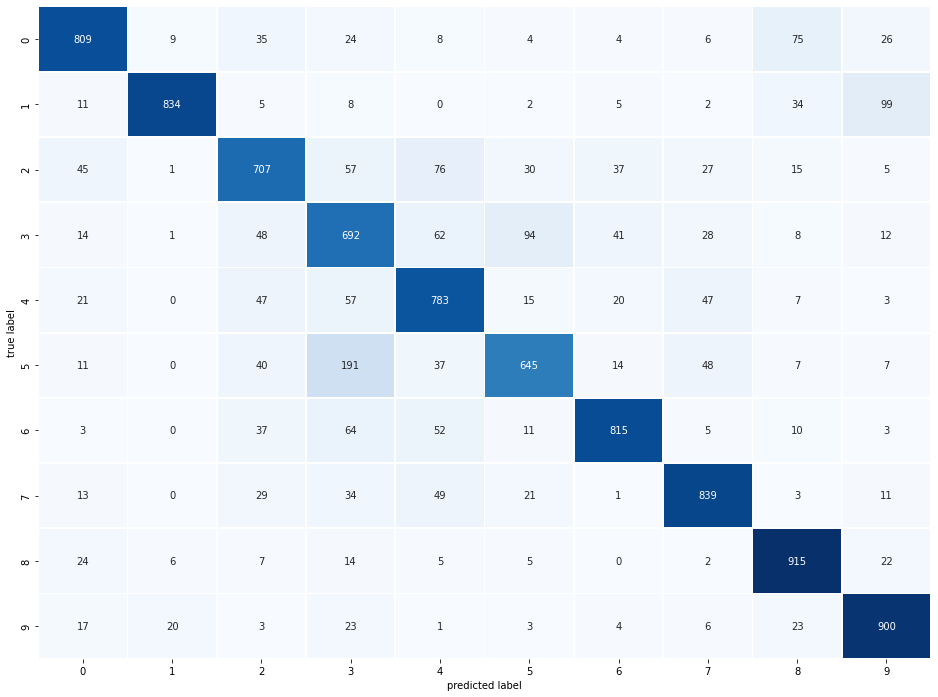

In [ ]:
plot_confusion_matrix(y_test,pred1)